In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [2]:
def load_and_preprocess_data(file_path):
    # Load the insurance data
    df = pd.read_csv(file_path)

    # Create risk indicator based on charges
    charge_threshold = df['charges'].quantile(0.75)
    df['high_risk'] = (df['charges'] > charge_threshold).astype(int)

    # Feature engineering
    df['age_group'] = pd.cut(df['age'],
                             bins=[0, 25, 35, 45, 55, 65, 100],
                             labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    df['bmi_category'] = pd.cut(df['bmi'],
                                bins=[0, 18.5, 24.9, 29.9, 100],
                                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

    # Convert categorical variables to dummy variables
    categorical_columns = ['sex', 'smoker', 'region', 'age_group', 'bmi_category']
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Save processed data for R
    df.to_csv('processed_insurance_data.csv', index=False)

    return df_encoded

In [3]:

def train_risk_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    return model, scaler, X_test, y_test, y_pred

In [4]:
def save_feature_importance(model, feature_names):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)
    importances.to_csv('feature_importances.csv', index=False)

In [9]:

if __name__ == "__main__":
    # Load and preprocess data
    df_encoded = load_and_preprocess_data('insurance.csv')

    # Prepare features and target
    X = df_encoded.drop(['charges', 'high_risk'], axis=1)
    y = df_encoded['high_risk']

    # Train model and get results
    model, scaler, X_test, y_test, y_pred = train_risk_model(X, y)

    # Print model performance
    print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Save feature importance for R visualization
    save_feature_importance(model, X.columns)

    # Save model and scaler for later use
    with open('insurance_risk_model.pkl', 'wb') as f:
        pickle.dump((model, scaler), f)



    # Example prediction function
    def predict_risk(age, sex, bmi, children, smoker, region):
        # Create a DataFrame with the new data
        new_data = pd.DataFrame({
            'age': [age],
            'sex': [sex],
            'bmi': [bmi],
            'children': [children],
            'smoker': [smoker],
            'region': [region]
        })

        # Apply the same preprocessing
        new_data['age_group'] = pd.cut(new_data['age'],
                                       bins=[0, 25, 35, 45, 55, 65, 100],
                                       labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
        new_data['bmi_category'] = pd.cut(new_data['bmi'],
                                          bins=[0, 18.5, 24.9, 29.9, 100],
                                          labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

        # Encode categorical variables
        categorical_columns = ['sex', 'smoker', 'region', 'age_group', 'bmi_category']
        new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns)

        # Ensure all columns match the training data
        for col in X.columns:
            if col not in new_data_encoded.columns:
                new_data_encoded[col] = 0
        new_data_encoded = new_data_encoded[X.columns]

        # Scale the data and make prediction
        new_data_scaled = scaler.transform(new_data_encoded)
        prediction = model.predict(new_data_scaled)
        probability = model.predict_proba(new_data_scaled)

        return prediction[0], probability[0][1]


     # Example usage
    sample_prediction, sample_probability = predict_risk(
        age=35, sex='male', bmi=28.5, children=2,
        smoker='yes', region='southwest'
    )
    print(f"\nSample Prediction:")
    print(f"Risk Category: {'High' if sample_prediction else 'Low'}")
    print(f"Probability of High Risk: {sample_probability:.2f}")

Model Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       202
           1       0.94      0.77      0.85        66

    accuracy                           0.93       268
   macro avg       0.94      0.88      0.90       268
weighted avg       0.93      0.93      0.93       268


Sample Prediction:
Risk Category: High
Probability of High Risk: 0.99


In [2]:
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 1338 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sex, smoker, region, age_group, bmi_category
dbl (5): age, bmi, children, charges, high_risk

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 21 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): feature
dbl (1): importance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


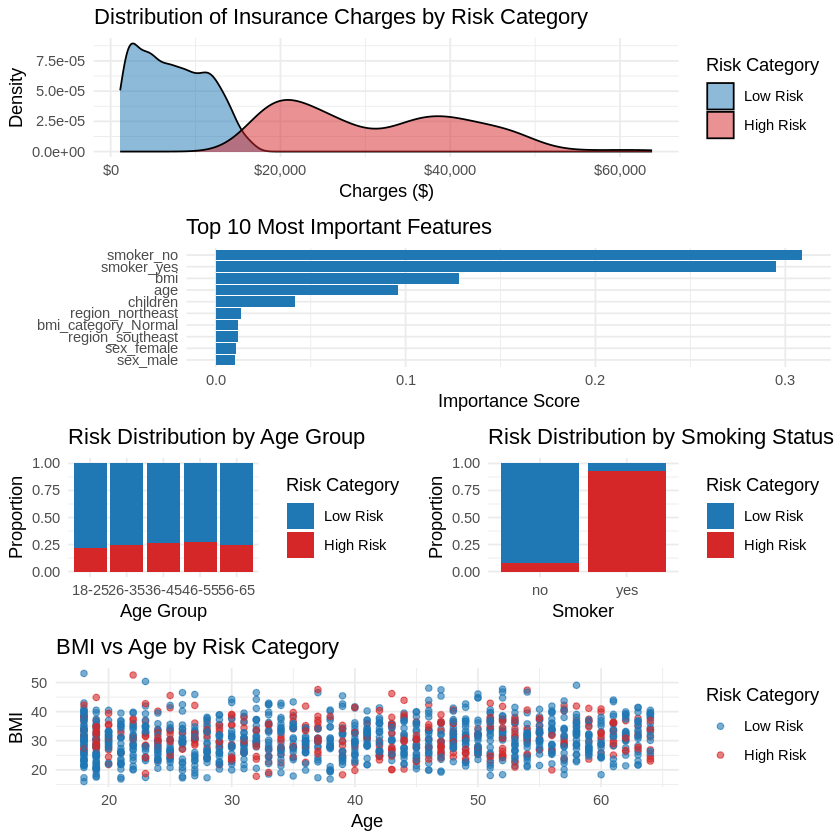

In [3]:
# Load required libraries
library(tidyverse)
library(ggplot2)
library(scales)
library(gridExtra)

# Read the processed data
insurance_data <- read_csv('processed_insurance_data.csv')
feature_importance <- read_csv('feature_importances.csv')

# 1. Risk Distribution Plot
risk_dist_plot <- ggplot(insurance_data, aes(x = charges, fill = factor(high_risk))) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("#1f77b4", "#d62728"),
                    labels = c("Low Risk", "High Risk")) +
  labs(title = "Distribution of Insurance Charges by Risk Category",
       x = "Charges ($)", y = "Density", fill = "Risk Category") +
  theme_minimal() +
  scale_x_continuous(labels = scales::dollar_format())

# 2. Feature Importance Plot
feature_importance_plot <- ggplot(head(feature_importance, 10),
                                 aes(x = reorder(feature, importance), y = importance)) +
  geom_bar(stat = "identity", fill = "#1f77b4") +
  coord_flip() +
  labs(title = "Top 10 Most Important Features",
       x = "", y = "Importance Score") +
  theme_minimal()

# 3. Risk Factors Analysis
age_risk_plot <- ggplot(insurance_data, aes(x = age_group, fill = factor(high_risk))) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c("#1f77b4", "#d62728"),
                    labels = c("Low Risk", "High Risk")) +
  labs(title = "Risk Distribution by Age Group",
       x = "Age Group", y = "Proportion", fill = "Risk Category") +
  theme_minimal()

smoker_risk_plot <- ggplot(insurance_data, aes(x = smoker, fill = factor(high_risk))) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c("#1f77b4", "#d62728"),
                    labels = c("Low Risk", "High Risk")) +
  labs(title = "Risk Distribution by Smoking Status",
       x = "Smoker", y = "Proportion", fill = "Risk Category") +
  theme_minimal()

# 4. BMI vs Age Plot with Risk
bmi_age_plot <- ggplot(insurance_data, aes(x = age, y = bmi, color = factor(high_risk))) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = c("#1f77b4", "#d62728"),
                     labels = c("Low Risk", "High Risk")) +
  labs(title = "BMI vs Age by Risk Category",
       x = "Age", y = "BMI", color = "Risk Category") +
  theme_minimal()

# Arrange plots in a grid
grid.arrange(risk_dist_plot, feature_importance_plot,
             arrangeGrob(age_risk_plot, smoker_risk_plot, ncol = 2),
             bmi_age_plot,
             ncol = 1)

# Save plots
ggsave("risk_distribution.png", risk_dist_plot, width = 10, height = 6)
ggsave("feature_importance.png", feature_importance_plot, width = 10, height = 6)
ggsave("risk_factors.png", arrangeGrob(age_risk_plot, smoker_risk_plot, ncol = 2),
       width = 12, height = 5)
ggsave("bmi_age_risk.png", bmi_age_plot, width = 10, height = 6)

# Generate summary statistics
summary_stats <- insurance_data %>%
  group_by(high_risk) %>%
  summarise(
    avg_age = mean(age),
    avg_bmi = mean(bmi),
    avg_charges = mean(charges),
    count = n()
  )

# Write summary statistics to file
write_csv(summary_stats, "risk_summary_statistics.csv")